# Morphing

## Entradas y salidas

Para poder hacer el morphing entre dos caras, vamos a necesitar dos imágenes de entrada que contengan las caras correspondientes. Estas deben estar en un formato más o menos estándar (como PNG o JPEG), pero valdrá cualquier formato que `cv2.imread` pueda leer.

Aquí surgen varias opciones:
- Podemos forzar al usuario a proporcionar imágenes con las caras ya alineadas y recortadas.
- Podemos intentar encontrar la cara en las imágenes automáticamente.

Si forzasemos al usuario a proporcionar imágenes con las caras ya alineadas y recortadas, habría que tener en cuenta estas consideraciones extra en las imágenes de entrada. Nuestra implementación toma la imagen, intenta ubicar la cara principal en la imagen y la recorta automáticamente. Si no encuentra la cara, asume que la imagen ya está recortada y continúa con el proceso. Por tanto, no hay muchas restricciones excepto que las caras estén suficientemente bien orientadas.

Nuestra función principal toma las rutas de las imágenes a parte de una serie de parámetros relacionados con el proceso cuyos tipos vienen indicados en la interfaz de las funciones.

En cuanto a las salidas, la función principal devuelve una lista de imágenes (arrays de numpy) que contienen los frames del morphing entre las dos caras. También pueden generar gráficos y animaciones para visualizar la secuencia de morphing.



## Preprocesamiento

En el procesamiento el paso principal es el de la detección facial para el cual utilizaremos un modelo pre-entrenado de OpenCV.

Hemos escalado las imágenes a un tamaño fijo (uno de los parámetros de la función), lo cual realmente no es necesario en este proceso, el transporte óptimo debería ser capaz de encontrar la correspondencia entre dos distribuciones aunque sean de tamaños diferentes. No obstante, esto ayuda a reducir el coste computacional, y al tener las imágenes tengan una resolución similar puede ayudar a mejorar la calidad del morphing.

También añadiremos un borde reflejado a las imágenes antes del morphing para evitar artefactos en los bordes de las imágenes resultantes. Estos artefactos se deben a estar interpolando linealmente respecto al plan de transporte, lo que causa que sea menos probable que en pasos intermedios haya píxeles en los bordes. No obstante, estos bordes son eliminados en el resultado final.

Además podría ser buena idea normalizar la iluminación entre las imágenes, para que el morphing sea más suave y exacto. Sin embargo, esto levanta un reto respecto a cómo aplicarlo entre personas con diferentes tonos de piel. Teniendo esto en cuenta y que realmente no es un paso necesario porque el morphing debería poder hallar la correspondencia entre ambas distribuciones aunque tengan diferentes iluminaciones, hemos decidido no implementarlo. De todas formas hemos probado a aplicar ecualización del histograma a las imágenes en escala de grises o incluso sobre las imágenes en color y no hemos notado una mejora significativa en los resultados, de hecho se veía más raro porque tenías que modificar las imágenes originales para que la evolución se mantuviera coherente y con personas con distintos tonos de piel se notaba demasiado esta adaptación.

La última consideración del procesamiento es respecto a que las imágenes intermedias tienen una tendencia a verse borrosas, incluso ajustando correctamente la regularización. Para mitigar este efecto, damos la opción de aplicar un aumento de nitidez a las imágenes intermedias. Esto permite también obtener resultados aceptables con valores de regularización más altos (menos computacionalmente costosos).

## Algoritmo principal

En última instancia, hemos optado por utilizar el algoritmo de Sinkhorn para realizar el morphing entre las dos imágenes. La idea principal es aplicar regularización entrópica al problema de transporte óptimo, lo que simula que hay una difusión gaussiana. La ventaja de este método es que únicamente controlando el parámetro de regularización podemos ajustar perfectamente el equilibrio entre calidad y coste computacional, ya que resulta ser una interpolación entre el transporte óptimo clásico y utilizar MMD (Maximum Mean Discrepancies); así como todos sus características algorítmicas pudiendo obtener puntos medios en cuanto a orden de complejidad, calidad de resultados, dimensionalidad, etc. (véase [1] para más detalles). Es por esta flexibilidad que hemos elegido este método.

Este algoritmo lo hemos aplicado sobre las imágenes en escala de grises, y posteriormente hemos aplicado el mismo plan de transporte a cada canal de color por separado. Las otras dos opciones que hemos valorado es hacerlo directamente todo en escala de grises (pero no se apreciaba bien las características faciales en las imágenes intermedias) o hacer un plan de transporte por cada canal de color (pero esto causaba artefactos como "arcoíris" en las imágenes intermedias puesto a que cada color se transportaba de forma independiente, y entonces no se mantenían coherentes las imágenes).

## Parámetros y decisiones de diseño

El algoritmo principal tiene los siguientes parámetros:
- `path_a` y `path_b`: Rutas de las imágenes a interpolar.
- `reg`: Parámetro de regularización para el algoritmo de Sinkhorn. Valores más altos hacen que el cálculo sea más rápido pero menos preciso (causa imágenes más borrosas). El valor por defecto es 1e-3, que en nuestras pruebas ofrece un buen equilibrio entre calidad y tiempo de cómputo.
- `max_iter`: Número máximo de iteraciones que se le permite al algoritmo de Sinkhorn para converger. Por defecto es 1000, que es el por defecto en la implementación actual de `POT`.
- `fracs`: Frames intermedios a generar entre las dos imágenes, es una lista de valores entre 0 y 1 que indican la proporción de cada imagen en el frame resultante. Hemos pensado que ofrece mayor flexibilidad que un número fijo de frames. Por defecto se genera 1 frame intermedio (0.5).
- `sharpness`: Parámetro para controlar el aumento de nitidez aplicado a las imágenes intermedias. Valores más altos hacen que las imágenes sean más nítidas, pero si es demasiado alto puede causar artefactos. Por defecto no aplica aumento de nitidez.
- `size`: Dimensiones a las que escalar las imágenes de entrada. Por defecto es (64, 64).
- `verbose`: Si es True, muestra un gráfico sencillo con las interpolaciones generadas. Por defecto es False.

Y devuelve una lista de arrays de numpy con las imágenes resultantes del morphing (incluidas la inicial y la final).

## Pruebas

In [1]:
from pathlib import Path
from itertools import combinations

import morphing

Processing: chris-pratt.jpg <-> dr-house.webp


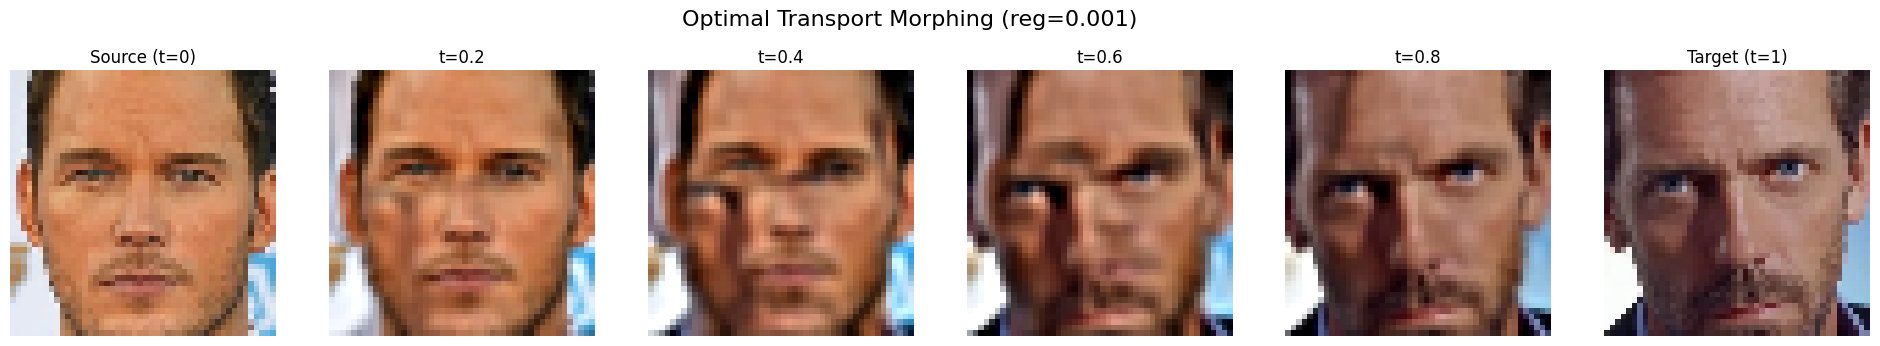

Processing: chris-pratt.jpg <-> lebron-james.jpg


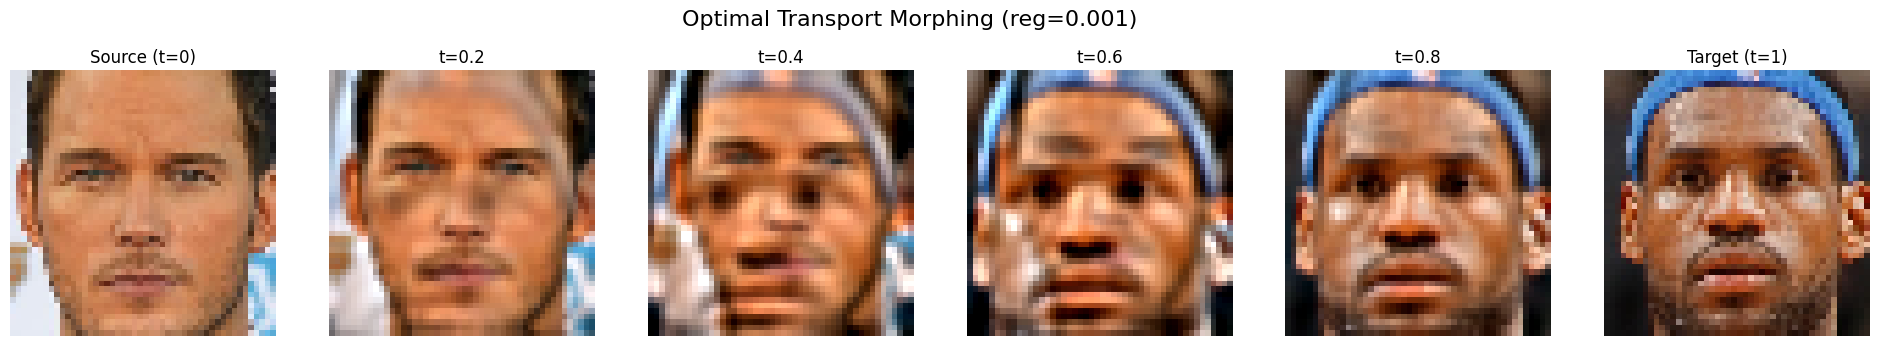

Processing: chris-pratt.jpg <-> shaquille-oneal.jpg


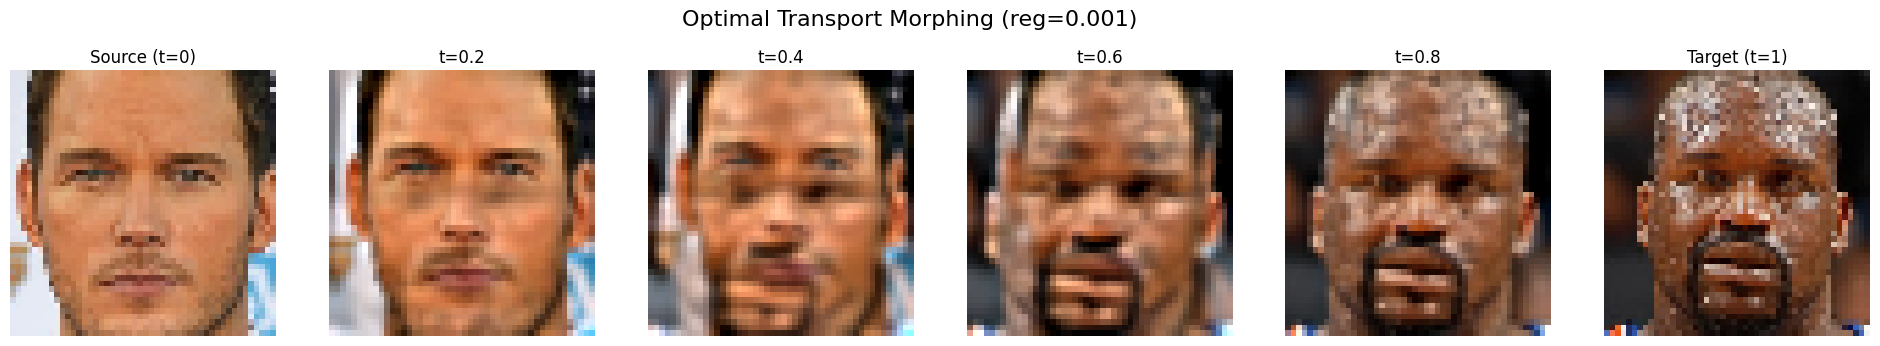

Processing: chris-pratt.jpg <-> walter-white.jpg


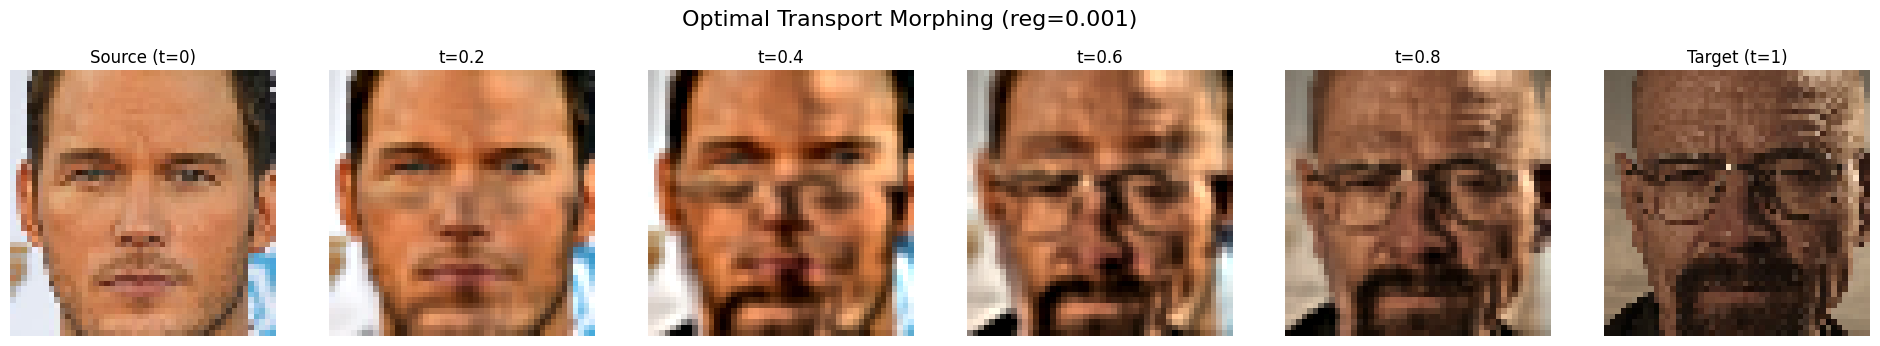

Processing: dr-house.webp <-> lebron-james.jpg


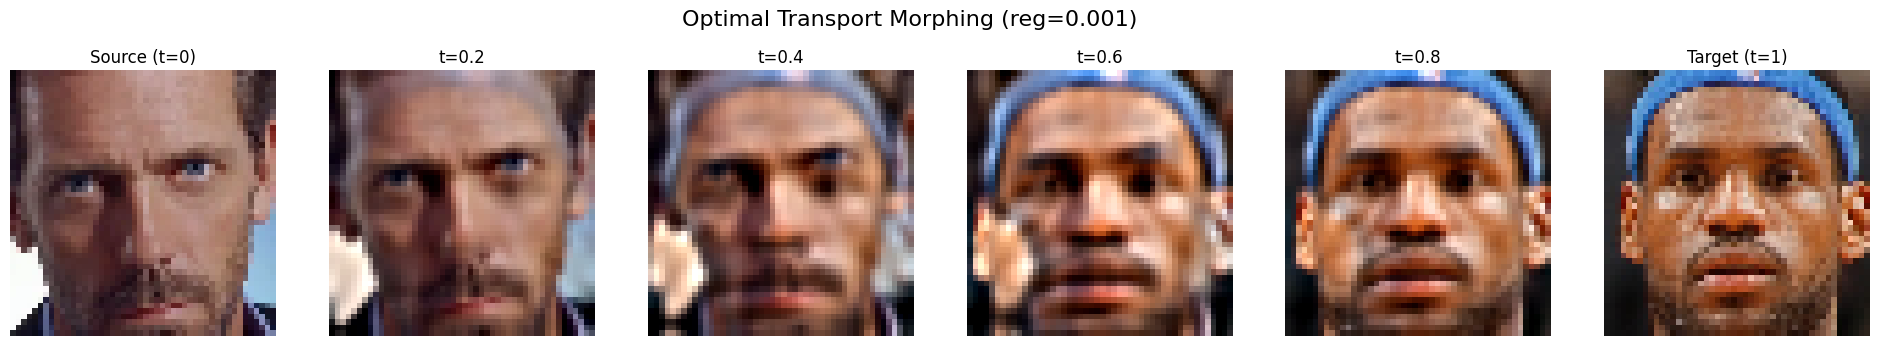

Processing: dr-house.webp <-> shaquille-oneal.jpg


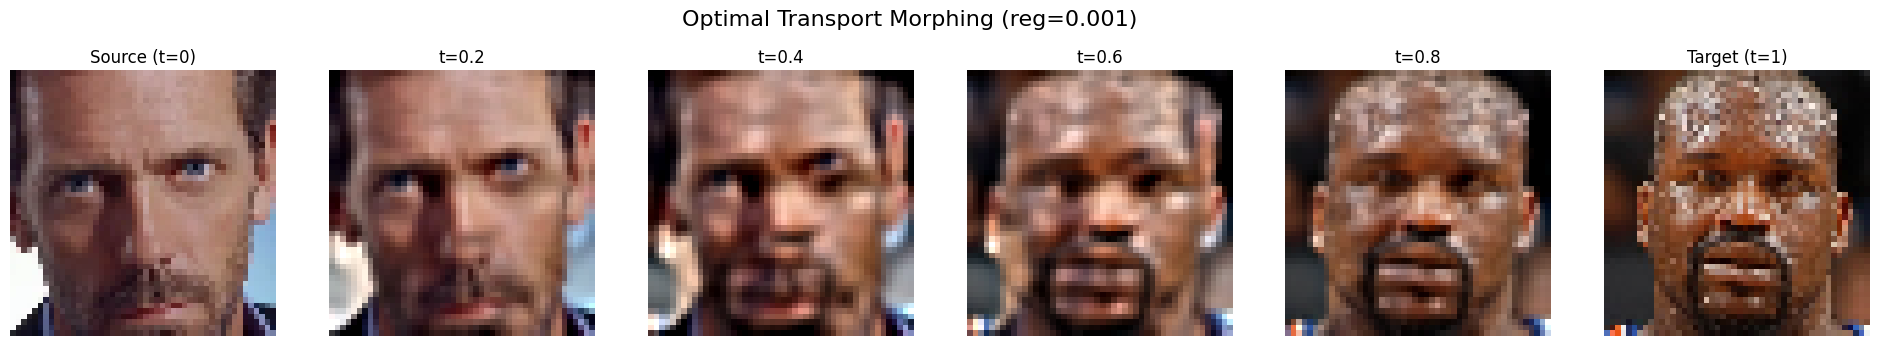

Processing: dr-house.webp <-> walter-white.jpg


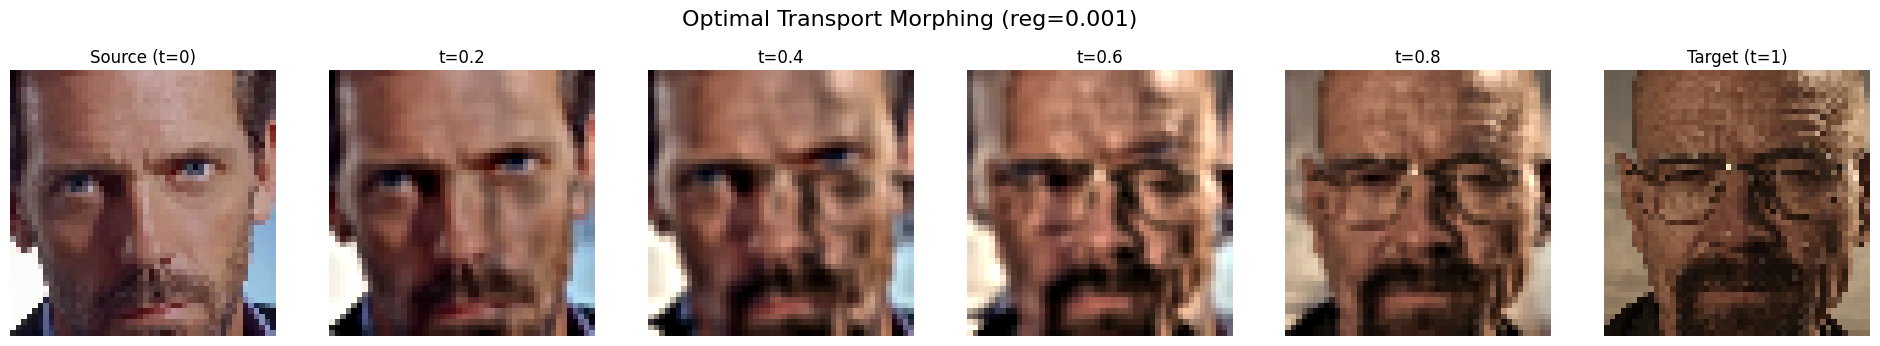

Processing: lebron-james.jpg <-> shaquille-oneal.jpg


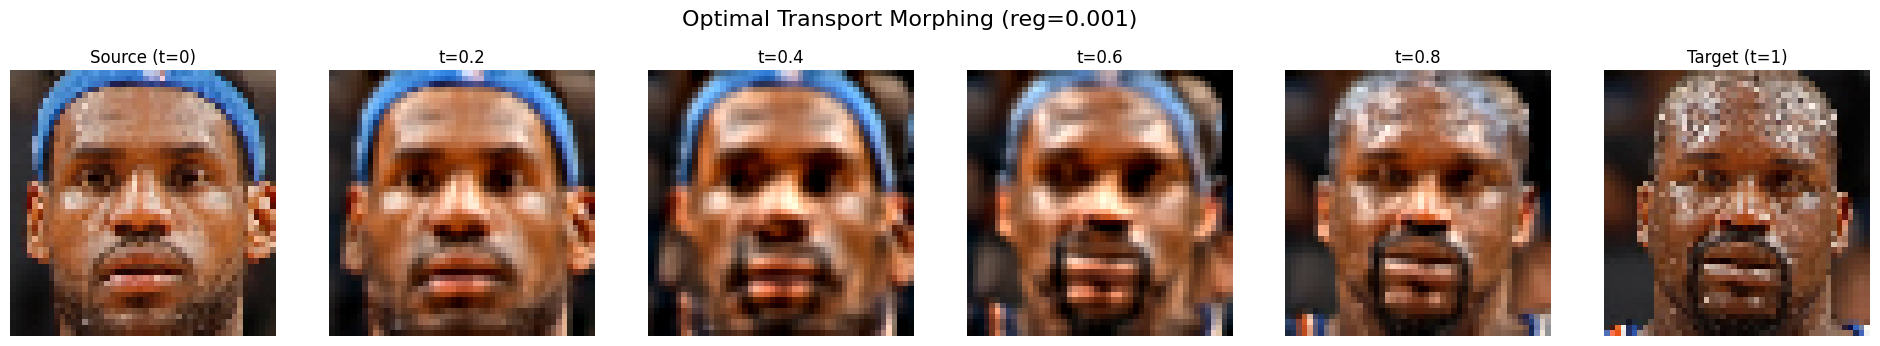

Processing: lebron-james.jpg <-> walter-white.jpg


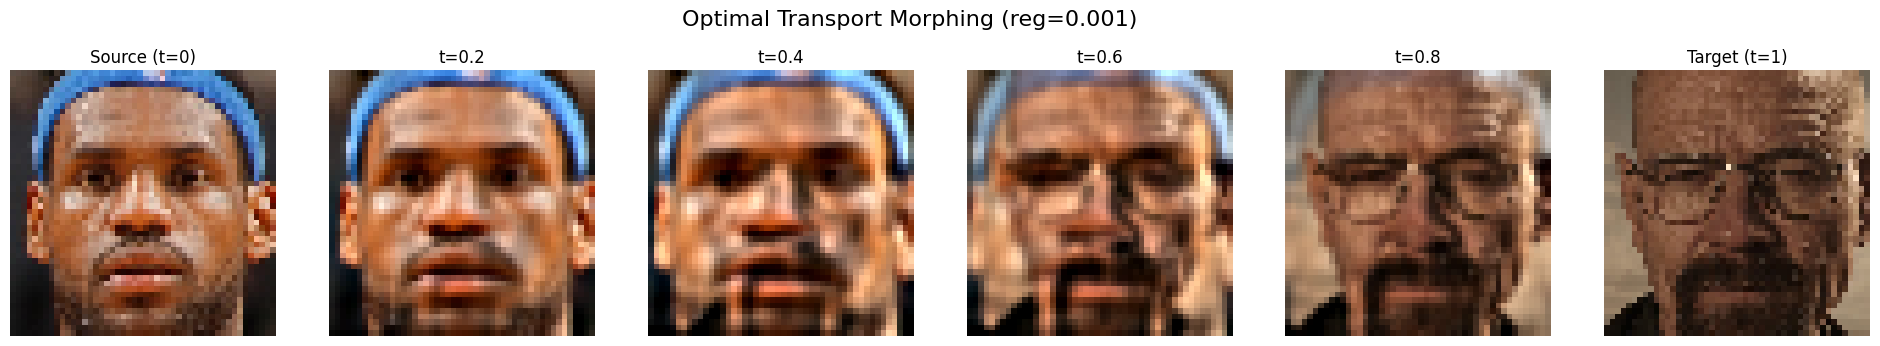

Processing: shaquille-oneal.jpg <-> walter-white.jpg


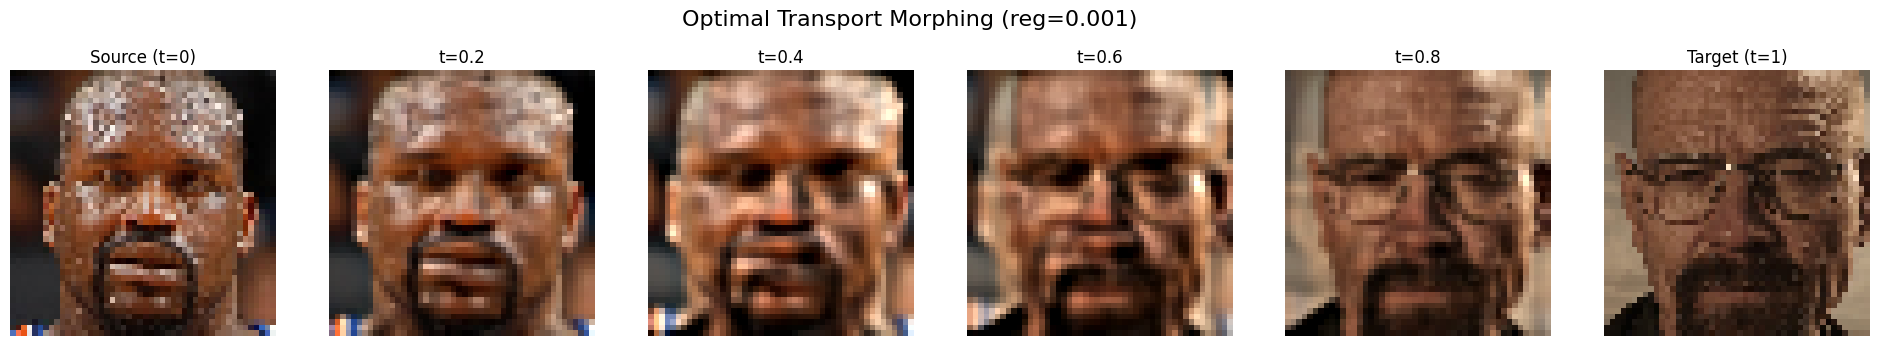

In [3]:
image_path = Path('images')
if not image_path.exists():
    image_path = Path('face-morphing') / 'images'
    if not image_path.exists():
        raise ValueError('Image path not found.')

image_paths = sorted(image_path.glob('*'))
frames = dict()
for image_a_path, image_b_path in combinations(image_paths, 2):
    
    print(f'Processing: {image_a_path.name} <-> {image_b_path.name}')
    frames[image_a_path.name, image_b_path.name] = morphing.process_and_morph_color(
        str(image_a_path),
        str(image_b_path),
        reg=1e-3,
        max_iter=5000,
        fracs=[0.2, 0.4, 0.6, 0.8],
        sharpness=2,
        size=(48, 48),
        verbose=True
    )
    

In [23]:
from random import randint
i = randint(0, len(frames)-1)
key = list(frames.keys())[i]
morphing.visualize_sequence(frames[key])

## Fuentes

[1] Genevay, A. (2020, 5 de febrero). Aude Genevay (MIT) -- Learning with Sinkhorn divergences: from optimal transport to MMD [Vídeo]. YouTube. https://www.youtube.com/watch?v=TFdIJib_zEA